In [17]:
import numpy as np
import torch
import torch_geometric as tg
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader, Batch
from torch_geometric.utils import degree
from torch.utils.data import random_split

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.models.gcn import ProtGCN

## Load the proteins dataset

In [2]:
dataset = TUDataset(root='./tmp/PROTEINS', name='PROTEINS').shuffle()

In [3]:
print('Number of graphs: ', len(dataset))
print('\n')
print('Number of features: ', dataset.num_features)
print('\n')
print('Number of classes: ', dataset.num_classes)
print('\n')

print(dataset[0])

Number of graphs:  1113


Number of features:  3


Number of classes:  2


Data(edge_index=[2, 96], x=[26, 3], y=[1])


## Split the dataset into train, validation and test sets

In [4]:
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

## Define the data loaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


##### Display the data batches

In [6]:
for batch in train_loader:
    print(batch)

DataBatch(edge_index=[2, 5608], x=[1367, 3], y=[32], batch=[1367], ptr=[33])
DataBatch(edge_index=[2, 3210], x=[825, 3], y=[32], batch=[825], ptr=[33])
DataBatch(edge_index=[2, 5174], x=[1505, 3], y=[32], batch=[1505], ptr=[33])
DataBatch(edge_index=[2, 4160], x=[1100, 3], y=[32], batch=[1100], ptr=[33])
DataBatch(edge_index=[2, 6108], x=[1525, 3], y=[32], batch=[1525], ptr=[33])
DataBatch(edge_index=[2, 4056], x=[1060, 3], y=[32], batch=[1060], ptr=[33])
DataBatch(edge_index=[2, 4286], x=[1119, 3], y=[32], batch=[1119], ptr=[33])
DataBatch(edge_index=[2, 6770], x=[1753, 3], y=[32], batch=[1753], ptr=[33])
DataBatch(edge_index=[2, 4536], x=[1219, 3], y=[32], batch=[1219], ptr=[33])
DataBatch(edge_index=[2, 3172], x=[833, 3], y=[32], batch=[833], ptr=[33])
DataBatch(edge_index=[2, 4390], x=[1240, 3], y=[32], batch=[1240], ptr=[33])
DataBatch(edge_index=[2, 5776], x=[1632, 3], y=[32], batch=[1632], ptr=[33])
DataBatch(edge_index=[2, 4858], x=[1259, 3], y=[32], batch=[1259], ptr=[33])
Dat

##### Visualize a graph sample of the dataset

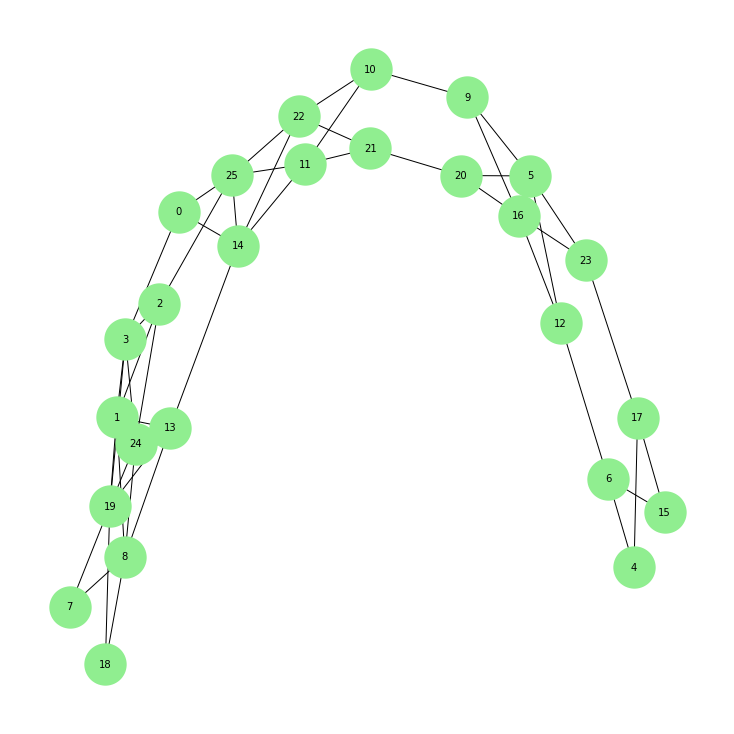

In [7]:
plt.figure(figsize=(10, 10))

graph = nx.Graph()

for i in range(len(dataset[0].edge_index[0])):
    graph.add_edge(dataset[0].edge_index[0][i].item(), dataset[0].edge_index[1][i].item())

nx.draw(graph, with_labels=True, node_size=500, node_color='lightgreen', edge_color='black', linewidths=20, font_size=10)
plt.show()

##### Visualize the first 40 graphs of the dataset

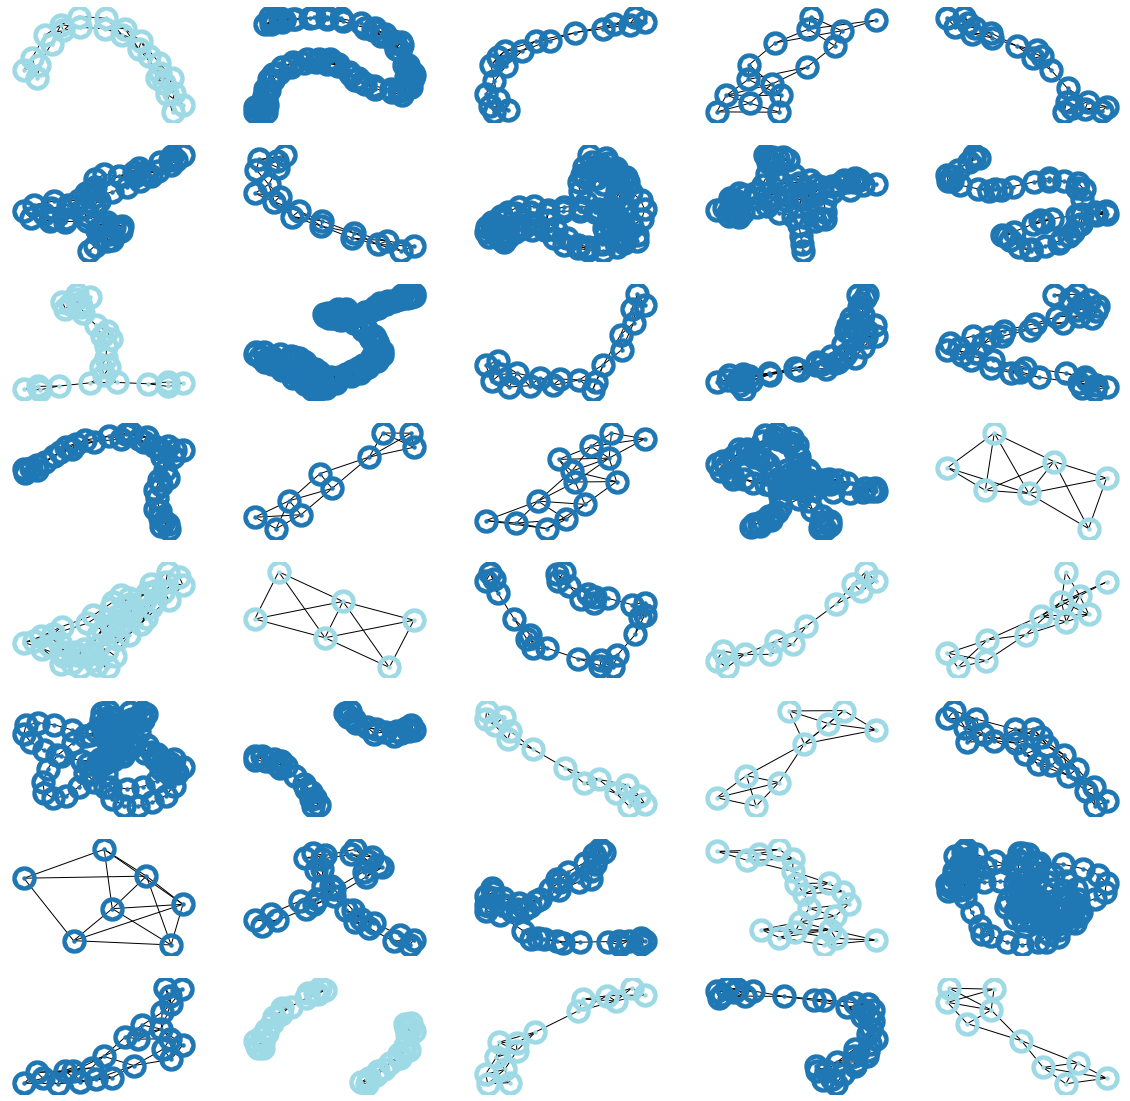

In [26]:
y_values = np.array([dataset[i].y.item() for i in range(len(dataset))])
unique_y = np.unique(y_values)
color_map = plt.get_cmap('tab20')(np.linspace(0, 1, len(unique_y)))
colors = dict(zip(unique_y, color_map))

fig, axs = plt.subplots(8, 5, figsize=(20, 20))

for i in range(40):
    graph = nx.Graph()
    for j in range(len(dataset[i].edge_index[0])):
        graph.add_edge(dataset[i].edge_index[0][j].item(), dataset[i].edge_index[1][j].item())
    node_colors = [colors[dataset[i].y.item()]]
    nx.draw(graph, with_labels=False, node_size=20, node_color=node_colors, linewidths=20, font_size=10, ax=axs[i//5, i%5])
    
plt.show()

## Define and build the model

In [136]:
model = ProtGCN(
    
    nfeatures=dataset.num_features,
    nclasses=dataset.num_classes,
    hidden_channels=32
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [137]:
print(model)

ProtGCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (linear): Linear(32, 2, bias=True)
)


##### Define the train and test functions

In [138]:

def train():
    
    model.train()
    
    acc = 0
    
    for data in train_loader:
        
        optimizer.zero_grad()
        
        _, out = model(data.x, data.edge_index, data.batch)
        
        loss = criterion(out, data.y)
        acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
        
        loss.backward()
        optimizer.step()
    
    return loss, acc

@torch.no_grad()
def test():
    
    model.eval()
    loss = 0
    acc = 0

    for data in test_loader:
        
        _, out = model(data.x, data.edge_index, data.batch)
        
        loss += criterion(out, data.y) / len(test_loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)
        
    return acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [139]:
NUMBER_OF_EPOCHS = 100

##### Run the training loop with 100 epochs

In [140]:
losses = []
accuracies = []

test_accs = []

for epoch in range(1, NUMBER_OF_EPOCHS):
    
    loss, acc = train()
    test_acc = test()
    
    if epoch % 10 == 0:
        losses.append(loss)
        accuracies.append(acc)
        test_accs.append(test_acc)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc*100: .2f} %, Test Acc: {test_acc*100:.2f} %')

Epoch: 001, Loss: 0.6968, Train Acc:  57.86 %, Test Acc: 53.91 %
Epoch: 002, Loss: 0.6263, Train Acc:  59.95 %, Test Acc: 51.56 %
Epoch: 003, Loss: 0.7168, Train Acc:  59.82 %, Test Acc: 51.56 %
Epoch: 004, Loss: 0.6529, Train Acc:  59.92 %, Test Acc: 52.34 %
Epoch: 005, Loss: 0.6945, Train Acc:  59.85 %, Test Acc: 54.69 %
Epoch: 006, Loss: 0.7125, Train Acc:  59.82 %, Test Acc: 55.47 %
Epoch: 007, Loss: 0.6390, Train Acc:  59.95 %, Test Acc: 53.12 %
Epoch: 008, Loss: 0.6808, Train Acc:  59.87 %, Test Acc: 53.91 %
Epoch: 009, Loss: 0.6948, Train Acc:  59.85 %, Test Acc: 53.91 %
Epoch: 010, Loss: 0.7274, Train Acc:  59.80 %, Test Acc: 53.91 %
Epoch: 011, Loss: 0.7103, Train Acc:  59.82 %, Test Acc: 52.34 %
Epoch: 012, Loss: 0.6668, Train Acc:  59.90 %, Test Acc: 53.91 %
Epoch: 013, Loss: 0.6879, Train Acc:  59.87 %, Test Acc: 53.12 %
Epoch: 014, Loss: 0.6667, Train Acc:  59.90 %, Test Acc: 54.69 %
Epoch: 015, Loss: 0.6672, Train Acc:  59.90 %, Test Acc: 51.56 %
Epoch: 016, Loss: 0.6671,

##### Visualize the training and testing losses and accuracies

In [141]:
losses_np = [loss.detach().numpy() for loss in losses]

In [142]:
losses_np_ = np.array(losses_np)

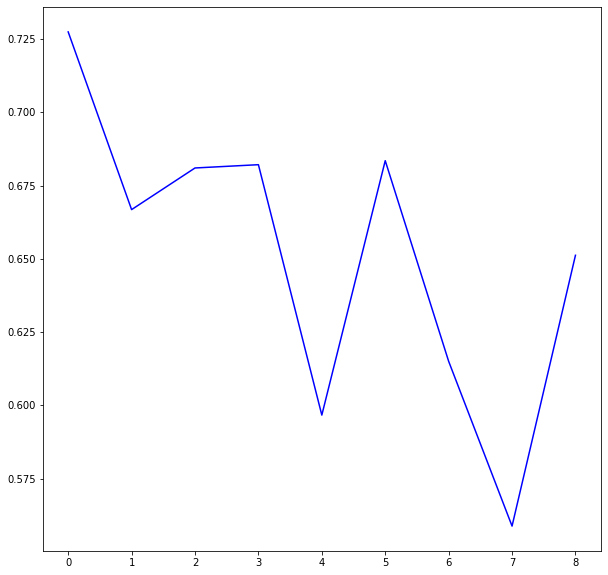

In [146]:
plt.figure(figsize=(10, 10))

plt.plot(losses_np_, color='blue', label='Loss')

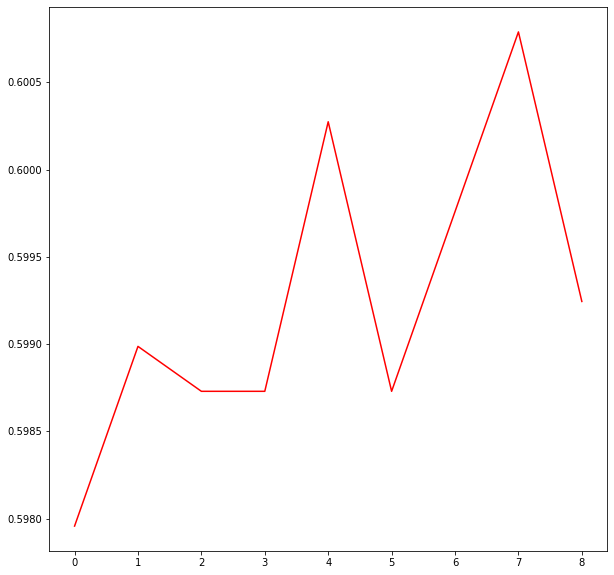

In [147]:
plt.figure(figsize=(10, 10))

plt.plot(accuracies, color='red', label='Train Accuracy')

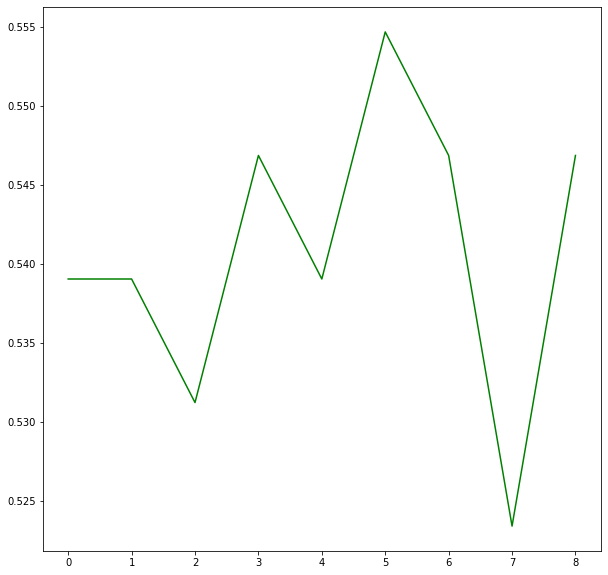

In [148]:
plt.figure(figsize=(10, 10))

plt.plot(test_accs, color='green', label='Test Accuracy')